# Setting

In [1]:
from pf_utils import BacktestManager, DataManager, StaticPortfolio, MomentumPortfolio, AssetEvaluator, metrics

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
metrics2 = [
    'cagr', 'monthly_vol', 'monthly_sharpe',
    'max_drawdown', 'avg_drawdown','avg_drawdown_days', 
]

path_data = 'data'
path_tran = 'transaction'

# Universe

In [3]:
file_k200 = 'kospi200_prices.csv'
file_etf = 'etfs_all.csv'
file_tdf = '금융자산운용 - export.csv'

download = False
close_today = False

## KOSPI200

In [4]:
k200 = DataManager(
    universe = 'KOSPI200',
    file = file_k200,
    path = path_data
)
k200.upload()

200 assets from 2021-01-04 to 2024-07-15 uploaded.
df_prices updated


In [5]:
kw = dict(
    n_years=3, 
    close_today=close_today,
    #tickers=k200.df_prices.columns
)
k200.download(**kw) if download else None

In [6]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

## ETF

In [7]:
etf = DataManager(
    universe = 'ETF',
    file = file_etf,
    path = path_data
)
etf.upload()

870 assets from 2021-01-04 to 2024-07-10 uploaded.
df_prices updated


In [8]:
kw = dict(
    n_years=3, 
    close_today=True,
    #tickers=etf.df_prices.columns
)
etf.download(**kw) if download else None

In [9]:
choice = ['069500', '273130', '148070', '379800', '411060', '284430']
df_etf = etf.df_prices[choice]
assetnames_etf = etf.get_names(tickers=choice)
assetnames_etf

0) 069500: KODEX 200
1) 273130: KODEX 종합채권(AA-이상)액티브
2) 148070: KOSEF 국고채10년
3) 379800: KODEX 미국S&P500TR
4) 411060: ACE KRX금현물
5) 284430: KODEX 200미국채혼합

## TDF
- https://www.kiwoomam.com/fund/KI0202020000M?parentfundcode=8325&fundcode=8335
- https://investments.miraeasset.com/fund/view.do?fundGb=2&fundCd=537380&childFundGb=2&childFundCd=53738P
- https://www.hanwhawm.com/main/finance/fundInfo/FI141_2.cmd?p=500&item_cd=5102896

In [10]:
tdf = DataManager(
    universe = 'TDF',
    file = file_tdf, upload_type = 'rate',
    path = path_data
)
tdf.upload()
tdf.get_date_range()

Estimating price from rate ...
  error: -0.07 %
  error: -0.00 %
  error: 0.16 %
  error: -0.13 %
  error: 0.00 %
5 assets from 2017-08-14 to 2024-07-15 uploaded.
df_prices updated


,start date,end date
K55301BU5479,2017-08-14,2024-06-16
K55301BU6139,2017-09-20,2024-07-14
K55301BU5453,2017-09-29,2024-06-16
K55206C96311,2018-07-13,2024-06-17
K55206C95800,2018-07-26,2024-07-15


In [11]:
df_tdf = tdf.df_prices
assetnames_tdf = tdf.get_names()
assetnames_tdf

0) K55301BU6139: 미래에셋전략배분TDF2035혼합자산자투자신탁종류C-P2e
1) K55206C95800: 키움키워드림TDF2030증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)
2) K55301BU5453: 미래에셋평생소득TIF혼합자산자투자신탁종류C-P2e
3) K55301BU5479: 미래에셋전략배분TDF2045혼합자산자투자신탁 종류C-P2e
4) K55206C96311: 키움키워드림TDF2045증권투자신탁 1[혼합-재간접형]C-P2e(퇴직연금)

# Backtest

## KOSPI 200

In [12]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 1, 
    days_in_year = 246,
    asset_names = assetnames_k200
)
bm = BacktestManager(df_k200, **kwargs_bm)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year


In [13]:
lags = dict(lookback=12, lag=5)

In [14]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [15]:
select = 'Momentum'
kwargs_build = dict(
    name=f'KOSPI:{select}', select =select,
    freq='M', weigh = 'ERC',
    n_assets=5, **lags
)
bm.build(**kwargs_build)

In [16]:
select = 'K-ratio'
kwargs_build.update(dict(
    name=f'KOSPI:{select}', select =select,
))
bm.build(**kwargs_build)

Backtesting 3 strategies: KODEX200, KOSPI:Momentum, KOSPI:K-ratio


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:58<00:00, 19.54s/it]

Returning stats


,KOSPI:Momentum,KOSPI:K-ratio,KODEX200
start,2021-01-03,2021-01-03,2021-01-03
end,2024-07-10,2024-07-10,2024-07-10
total_return,5.853925,1.574613,0.074952
cagr,0.728994,0.308676,0.020773
calmar,2.773416,1.458469,0.074662
max_drawdown,-0.262851,-0.211644,-0.278222
avg_drawdown,-0.059227,-0.030276,-0.061003
avg_drawdown_days,17.488372,18.261905,180.0
daily_vol,0.390676,0.229753,0.145827
daily_sharpe,1.625152,1.31014,0.216688


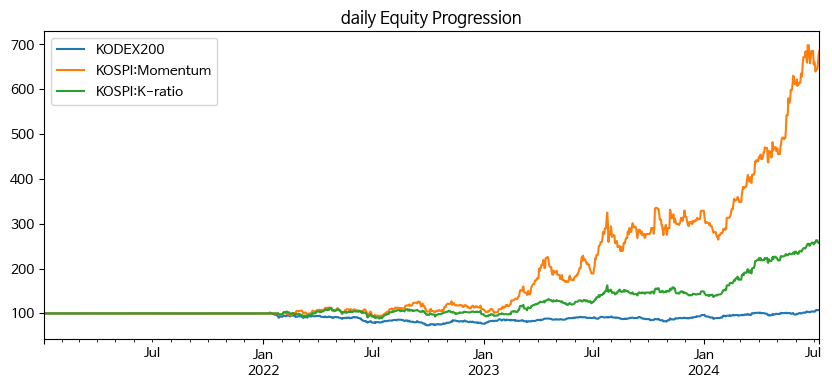

In [17]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [18]:
df_pf = bm.get_historical()
df_pf = df_pf[['KODEX200','KOSPI:Momentum']]

## ETF

In [19]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 245,
    asset_names = assetnames_etf
)
bm = BacktestManager(df_etf, **kwargs_bm)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year


In [20]:
lags = dict(lookback=12, lag=5)

In [21]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [22]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='ETF:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='ETF:ERC', weigh='ERC', **kwargs_build)
bm.build(name='ETF:InvVol', weigh='InvVol', **kwargs_build)

Backtesting 4 strategies: KODEX200, ETF:Eqaully, ETF:ERC, ETF:InvVol


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.78it/s]


Returning stats


,ETF:Eqaully,ETF:ERC,ETF:InvVol,KODEX200
start,2021-12-14,2021-12-14,2021-12-14,2021-12-14
end,2024-07-10,2024-07-10,2024-07-10,2024-07-10
total_return,0.261244,0.214048,0.190885,0.341347
cagr,0.094482,0.078365,0.070315,0.121013
calmar,2.570011,2.036211,1.863784,0.960111
max_drawdown,-0.036763,-0.038486,-0.037727,-0.126041
avg_drawdown,-0.007851,-0.007471,-0.00685,-0.025636
avg_drawdown_days,12.771429,17.346154,17.461538,19.68
daily_vol,0.046101,0.040422,0.038887,0.125812
daily_sharpe,2.030856,1.93376,1.810946,0.993648


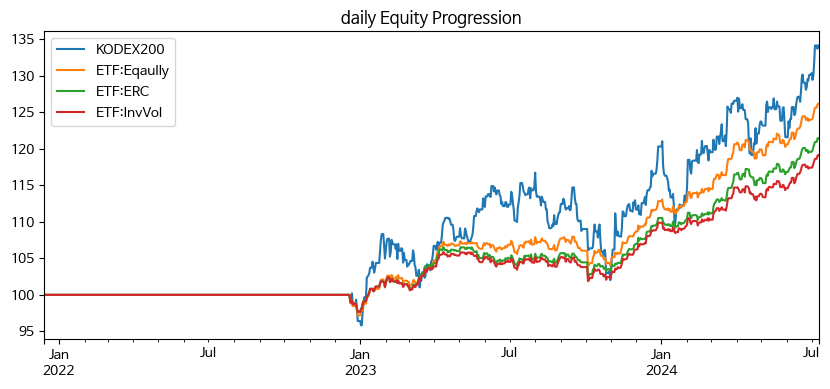

In [23]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [24]:
df = bm.get_historical()
df_pf = df_pf.join(df[['ETF:Eqaully', 'ETF:ERC']])

## TDF

In [25]:
kwargs_bm = dict(
    initial_capital = 10000000,
    commissions = 0,
    align_axis = 0, 
    days_in_year = 365,
    asset_names = assetnames_tdf
)
bm = BacktestManager(df_tdf, **kwargs_bm)

period reset: 2018-07-26 ~ 2024-06-16
running self.util_check_days_in_year to check days in a year


In [26]:
lags = dict(lookback=12, lag=5)

In [27]:
bm.benchmark_ticker(**lags)

Benchmark is KODEX200


In [28]:
kwargs_build = dict(
    freq = 'Y', select = 'all',
    **lags # added to start backtest on same date with momentum
)

bm.build(name='TDF:Eqaully', weigh='equally', **kwargs_build)
bm.build(name='TDF:ERC', weigh='ERC', **kwargs_build)
bm.build(name='TDF:InvVol', weigh='InvVol', **kwargs_build)

In [29]:
choice = ['K55301BU6139', 'K55206C95800']

kwargs_build.update(dict(
    name='TDF2:Eqaully', select ='all', 
    weigh='Specified',  weights=choice
))
bm.build(**kwargs_build)

Backtesting 5 strategies: KODEX200, TDF:Eqaully, TDF:ERC, TDF:InvVol, TDF2:Eqaully


100%|█████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]

Returning stats


,TDF2:Eqaully,TDF:Eqaully,TDF:InvVol,TDF:ERC,KODEX200
start,2018-07-25,2018-07-25,2018-07-25,2018-07-25,2018-07-25
end,2024-06-14,2024-06-14,2024-06-14,2024-06-14,2024-06-14
total_return,0.386717,0.369804,0.334643,0.338897,0.548027
cagr,0.057086,0.054885,0.050238,0.050805,0.077024
calmar,0.264737,0.264097,0.262103,0.262441,0.222392
max_drawdown,-0.215632,-0.207823,-0.191671,-0.193587,-0.346343
avg_drawdown,-0.01504,-0.014127,-0.012421,-0.012834,-0.041874
avg_drawdown_days,32.085106,31.333333,29.86,30.653061,53.935484
daily_vol,0.066812,0.064454,0.058252,0.058886,0.183777
daily_sharpe,0.884602,0.881452,0.891091,0.891528,0.505265


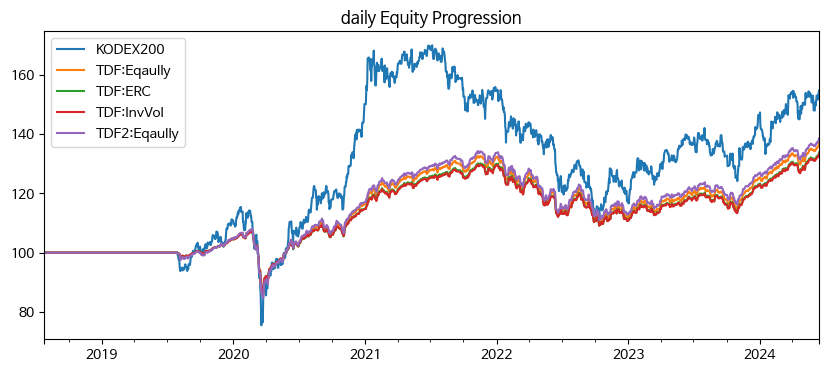

In [30]:
bm.run(figsize=(10,4), stats_sort_by='monthly_sharpe')

In [31]:
df = bm.get_historical()
df_pf = df_pf.join(df['TDF2:Eqaully'])

## Summary

In [32]:
ae = AssetEvaluator(df_pf, 245)

ETF:Eqaully: 151
ETF:ERC: 151
TDF2:Eqaully: 237


In [33]:
ae.get_stats(sort_by='monthly_sharpe', align_period=False)

,ETF:Eqaully,ETF:ERC,KOSPI:Momentum,TDF2:Eqaully,KODEX200
start,2022-12-19,2022-12-19,2022-01-25,2022-01-10,2022-01-10
end,2024-07-10,2024-07-10,2024-07-10,2024-06-14,2024-07-10
total_return,0.261244,0.214048,5.853925,0.048404,0.074952
cagr,0.160659,0.132589,1.18971,0.019678,0.029369
calmar,4.37009,3.44514,4.526184,0.120567,0.10556
max_drawdown,-0.036763,-0.038486,-0.262851,-0.16321,-0.278222
avg_drawdown,-0.007851,-0.007471,-0.059227,-0.02669,-0.061003
avg_drawdown_days,12.771429,17.346154,17.488372,106.375,180.0
daily_vol,0.059009,0.051766,0.467761,0.068992,0.173421
daily_sharpe,2.624961,2.498196,1.953838,0.324167,0.257587


# Transaction

## KOSPI200

In [7]:
kwargs = dict(
    name='KOSPI Momentum',
    file='pf_k200_momentum.csv',
    method_select='Simple', method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=246,
    asset_names=assetnames_k200,
)

pf_k200 = MomentumPortfolio(df_k200, **kwargs)

15 assets removed for shorter periods (7.5%)
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-05-14 loaded.


In [16]:
kwargs = dict(
    date = '2024-05-15',
    #date = None,
    n_assets = 5,
    capital = 0,
    #save = False
    save = True
)
df = pf_k200.transaction_pipeline(**kwargs)

5 assets selected by Total return from 2023-05-09 to 2024-05-09
Weights of assets determined by ERC.
Mean absolute error of weights: 3 %
Value 17,395,350, Profit 5,290,300
All transactions saved to pf_k200_momentum_240514.csv


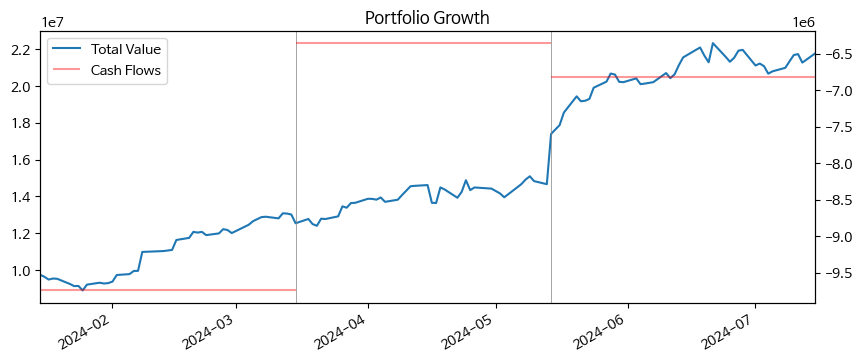

In [8]:
pf_k200.plot()

In [14]:
pf_k200.performance(metrics=metrics)

,KOSPI Momentum
start,2024-01-15
end,2024-07-15
total_return,0.362114
cagr,0.859297
calmar,3.367966
max_drawdown,-0.255138
avg_drawdown,-0.065739
avg_drawdown_days,18.375
daily_vol,0.609935
daily_sharpe,1.375633


In [38]:
#pf_k200.performance(metrics=metrics2)
df_pf = pf_k200.get_historical()

## ETF

In [39]:
kwargs = dict(
    name='ETF6',
    file='pf_etf_static.csv',
    method_weigh='ERC', lookback=12, lag=5,
    path=path_tran,
    days_in_year=245,
    asset_names=assetnames_etf,
)

pf_etf = StaticPortfolio(df_etf, **kwargs)

period reset: 2021-12-15 ~ 2024-07-10
running self.util_check_days_in_year to check days in a year
REMINDER: make sure this is 1st transaction as no records provided


In [40]:
pf_etf.plot()

ERROR: No transaction record


In [41]:
pf_etf.performance(metrics=metrics)

ERROR: No transaction record


In [42]:
pf_etf.transaction_pipeline(save=False)

6 assets from 2023-07-05 to 2024-07-05 prepared for weight analysis
Weights of assets determined by ERC.
Value 9,894,915, Profit 0
Set save=True to save transaction record


name   price  transaction  net weight
date       asset                                                        
2024-07-10 069500             KODEX 200   39735           21   21   0.08
           148070          KOSEF 국고채10년  114330           16   16   0.18
           273130  KODEX 종합채권(AA-이상)액티브  112380           24   24   0.27
           284430        KODEX 200미국채혼합   13490          117  117   0.16
           379800      KODEX 미국S&P500TR   17560           88   88   0.16
           411060            ACE KRX금현물   15005           94   94   0.14

In [43]:
df_pf = df_pf.to_frame().join(pf_etf.get_historical(), how='outer')

## TDF

In [44]:
choice = ['K55301BU6139', 'K55206C95800']

In [45]:
kwargs = dict(
    name='TDF2',
    file='pf_tdf_static.csv',
    lookback=12, lag=5,
    path=path_tran,
    days_in_year=365,
    asset_names=assetnames_tdf,
)

pf_tdf = StaticPortfolio(df_tdf[choice], **kwargs)

period reset: 2018-07-26 ~ 2024-07-14
running self.util_check_days_in_year to check days in a year
Transaction record to 2024-06-19 loaded.


In [46]:
kwargs = dict(
    method_weigh = 'Equally', 
    date = '2024-06-19',
    save = True
)
df = pf_tdf.transaction_pipeline(**kwargs)

2 assets from 2023-06-14 to 2024-06-14 prepared for weight analysis
ERROR: check the date as no new transaction
The profit from the most recent transaction: 0


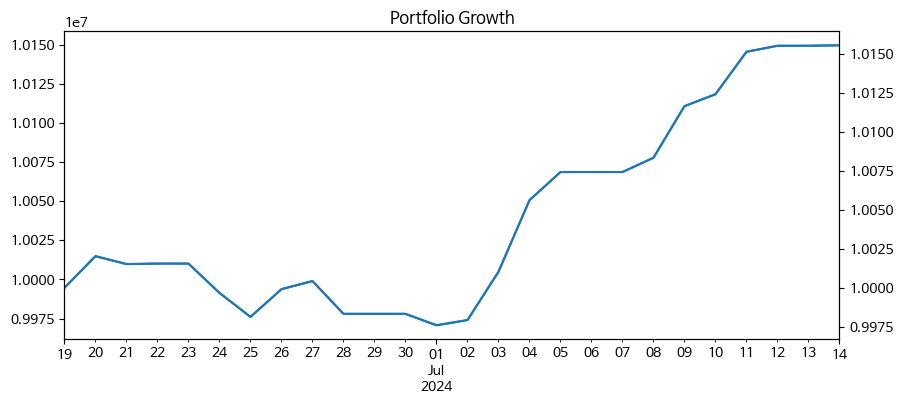

In [47]:
pf_tdf.plot()

In [48]:
pf_tdf.performance(metrics=metrics)

,TDF2
start,2024-06-19
end,2024-07-14
total_return,0.01553
cagr,0.252514
calmar,57.175393
max_drawdown,-0.004416
avg_drawdown,-0.004416
avg_drawdown_days,13.0
daily_vol,0.025607
daily_sharpe,6.080427


In [49]:
df_pf = df_pf.join(pf_tdf.get_historical(), how='outer')
df_pf.tail()

,KOSPI Momentum,ETF6,TDF2
2024-07-10,9179800.0,9894915.0,1.011854e+07
2024-07-11,NaN,NaN,1.014572e+07
2024-07-12,NaN,NaN,1.014957e+07
2024-07-13,NaN,NaN,1.014957e+07
2024-07-14,NaN,NaN,1.014988e+07


## Summary

In [50]:
ae = AssetEvaluator(df_pf, 242)
ae.get_stats(sort_by='monthly_sharpe', align_period=False)

KOSPI Momentum: 0
ETF6: 0
TDF2: 0


,KOSPI Momentum,ETF6,TDF2
start,2024-07-10,2024-07-10,2024-06-19
end,2024-07-10,2024-07-10,2024-07-14
total_return,NaN,NaN,0.01553
cagr,NaN,NaN,0.252514
calmar,NaN,NaN,57.175393
max_drawdown,NaN,NaN,-0.004416
avg_drawdown,NaN,NaN,-0.004416
avg_drawdown_days,NaN,NaN,13.0
daily_vol,NaN,NaN,0.025607
daily_sharpe,NaN,NaN,6.080427


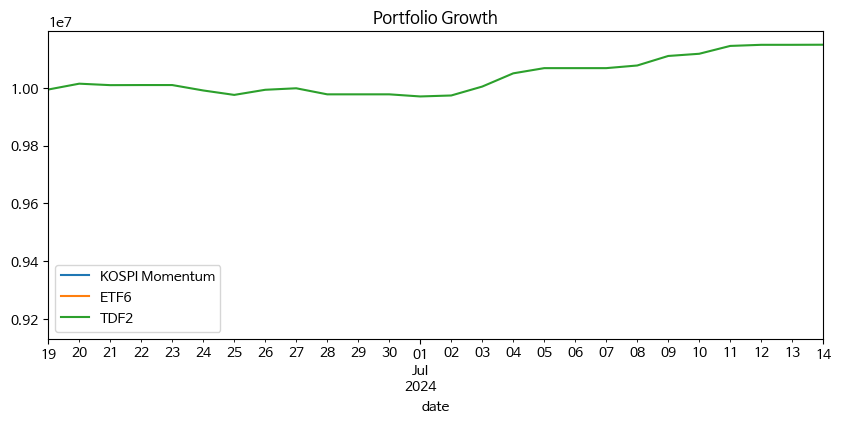

In [51]:
_ = ae.plot_historical()

In [10]:
def calc_value(self, record, profit=False):
    """
    calc asset value and profit
    """
    col_prc = self.cols_record['prc']
    col_trs = self.cols_record['trs']
    col_net = self.cols_record['net']
    cost = record[col_prc].mul(record[col_trs]).sum()
    date = record.index.get_level_values(0).max()
    bal = record.loc[date].apply(lambda x: x[col_prc] * x[col_net], axis=1).sum()
    if profit: # return profit
        return bal-cost
    else: # return total value (asset value + profit)
        return 2*bal-cost


calc_value(pf_k200, df_rec)

17395350

In [17]:
import pandas as pd

def calc_cashflow(self, record):
    col_prc = self.cols_record['prc']
    col_trs = self.cols_record['trs']
    col_date = self.cols_record['date']
    return record[col_prc].mul(record[col_trs]).groupby(col_date).sum().cumsum().mul(-1)
    

df_cf = calc_cashflow(pf_k200, df_rec)
#df_cf = df_cf.reindex(df_cf.index.union(df_cf.index.shift(-1, freq='D'))).ffill().dropna()
df_cf

date
2024-01-15   -9740300
2024-03-15   -6354200
2024-05-14   -6814750
dtype: int64

In [18]:
df_cf = df_cf.rename('y').rename_axis('x1').reset_index()
df_cf = df_cf.join(df_cf.x1.shift(-1).rename('x2')).fillna(sr_historical.index.max())
df_cf = df_cf[['y', 'x1', 'x2']]

In [19]:
args_vline = [x.to_list() for _, x in df_cf.iterrows()]

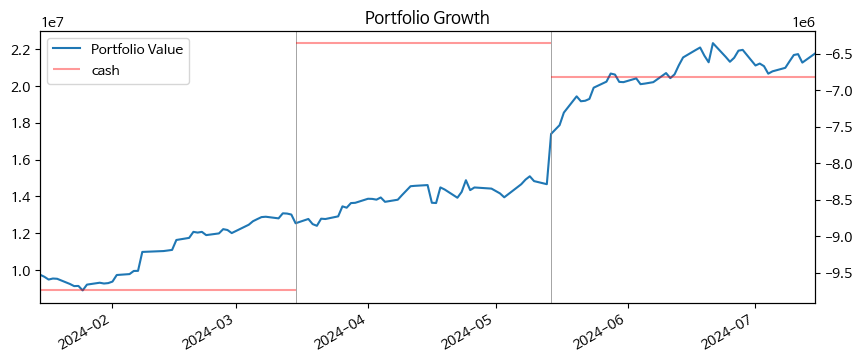

In [49]:
self = pf_k200

figsize=(10,4)
"""
plot total value of portfolio
"""
df_rec = self._check_result()

sr_historical = self._calc_historical(df_rec, self.name)
dates_trs = df_rec.index.get_level_values(0).unique()
    
ax = sr_historical.plot(figsize=figsize, title='Portfolio Growth', label='Total Value')
ax.vlines(dates_trs, 0, 1, transform=ax.get_xaxis_transform(), lw=0.5, color='grey')
ax.autoscale(enable=True, axis='x', tight=True)

#ax2 = ax.twinx()
#_ = df_cf.plot(ax=ax2, color='r', lw=0.5)
#ax2.autoscale(enable=True, axis='x', tight=True)

ax2 = ax.twinx()
_ = [ax2.hlines(*a, label='Cash Flows', alpha=0.4, color= 'r' if a[0] < 0 else 'g') for a in args_vline]
#ax2.autoscale(enable=True, axis='x', tight=True)

h, _ = ax.get_legend_handles_labels()
h2, _ = ax2.get_legend_handles_labels()
ax.legend(handles=[h[0], h2[0]])

In [48]:
h2

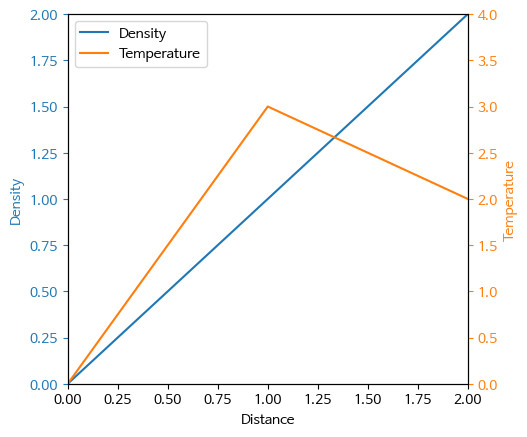

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
#twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#twin2.spines.right.set_position(("axes", 1.2))

p1, = ax.plot([0, 1, 2], [0, 1, 2], "C0", label="Density")
p2, = twin1.plot([0, 1, 2], [0, 3, 2], "C1", label="Temperature")

ax.set(xlim=(0, 2), ylim=(0, 2), xlabel="Distance", ylabel="Density")
twin1.set(ylim=(0, 4), ylabel="Temperature")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())

ax.legend(handles=[p1, p2])

plt.show()

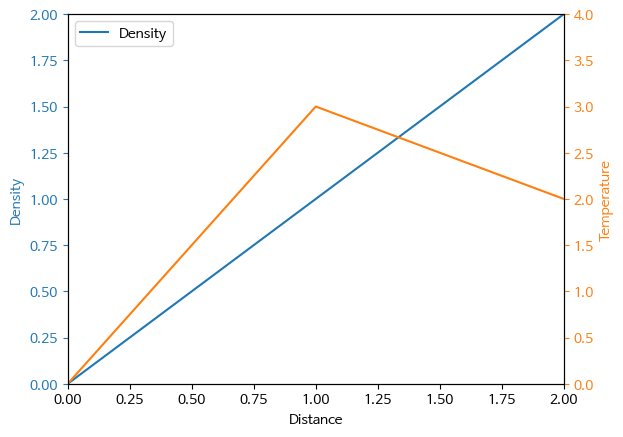

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

p1, = ax.plot([0, 1, 2], [0, 1, 2], "C0", label="Density")
p2, = twin1.plot([0, 1, 2], [0, 3, 2], "C1", label="Temperature")

ax.set(xlim=(0, 2), ylim=(0, 2), xlabel="Distance", ylabel="Density")
twin1.set(ylim=(0, 4), ylabel="Temperature")

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())

#ax.legend(handles=[p1, p2])
ax.legend()
plt.show()